In [7]:
import matplotlib
from matplotlib.ticker import LogLocator, MultipleLocator
import matplotlib.pyplot as plt
import pandas as pd
from plotConvergence import plot, getThresholds
import seaborn as sns
import numpy as np
from pathlib import Path

pd.set_option('display.max_rows', None)

dir_calcs = Path('').absolute().joinpath('calcs_zora_mw8_take1')
files = dir_calcs.glob('*.out')

In [8]:
def getNumOrbitals(lines):
    return [int(line.split()[3]) for line in lines if line.strip().startswith('Total electrons')][0]

In [9]:
def getOrbitalResiduals(lines):
    headers = ['n', 'Spin', 'Nodes', 'F(i,i)', 'Residual', 'Done']
    norbs = getNumOrbitals(lines)
    table = []
    scf_iter = -1
    for i, line in enumerate(lines):
        if all([h in line for h in headers]):
            for orbline in lines[i+2:i+2+norbs]:
                idx, spin, nodes, eps, res, done = orbline.split()
                if int(idx) == 0:
                    scf_iter += 1
                
                row = (scf_iter, int(idx), spin, float(eps), float(res), int(done))
                table.append(row)
    return table

In [10]:
def getyTicks(r):
    maxExp = np.ceil(np.log10(np.max(r)))
    minExp = np.floor(np.log10(np.min(r)))
    ticks = [10**exp for exp in np.arange(minExp, maxExp, 1)]
    return ticks

/Users/abr121/Documents/dev/proj_zora/row5/calcs_zora_mw8_take1/Cd_pbe.out
/Users/abr121/Documents/dev/proj_zora/row5/calcs_zora_mw8_take1/Tc_pbe.out
/Users/abr121/Documents/dev/proj_zora/row5/calcs_zora_mw8_take1/Rh_pbe.out
/Users/abr121/Documents/dev/proj_zora/row5/calcs_zora_mw8_take1/Y_pbe.out
/Users/abr121/Documents/dev/proj_zora/row5/calcs_zora_mw8_take1/Ru_pbe.out
/Users/abr121/Documents/dev/proj_zora/row5/calcs_zora_mw8_take1/Pd_pbe.out
/Users/abr121/Documents/dev/proj_zora/row5/calcs_zora_mw8_take1/Rb_pbe.out
/Users/abr121/Documents/dev/proj_zora/row5/calcs_zora_mw8_take1/In_pbe.out
/Users/abr121/Documents/dev/proj_zora/row5/calcs_zora_mw8_take1/Te_pbe.out
/Users/abr121/Documents/dev/proj_zora/row5/calcs_zora_mw8_take1/Sr_pbe.out
/Users/abr121/Documents/dev/proj_zora/row5/calcs_zora_mw8_take1/Mo_pbe.out
/Users/abr121/Documents/dev/proj_zora/row5/calcs_zora_mw8_take1/Sn_pbe.out
/Users/abr121/Documents/dev/proj_zora/row5/calcs_zora_mw8_take1/Xe_pbe.out
/Users/abr121/Documents/de

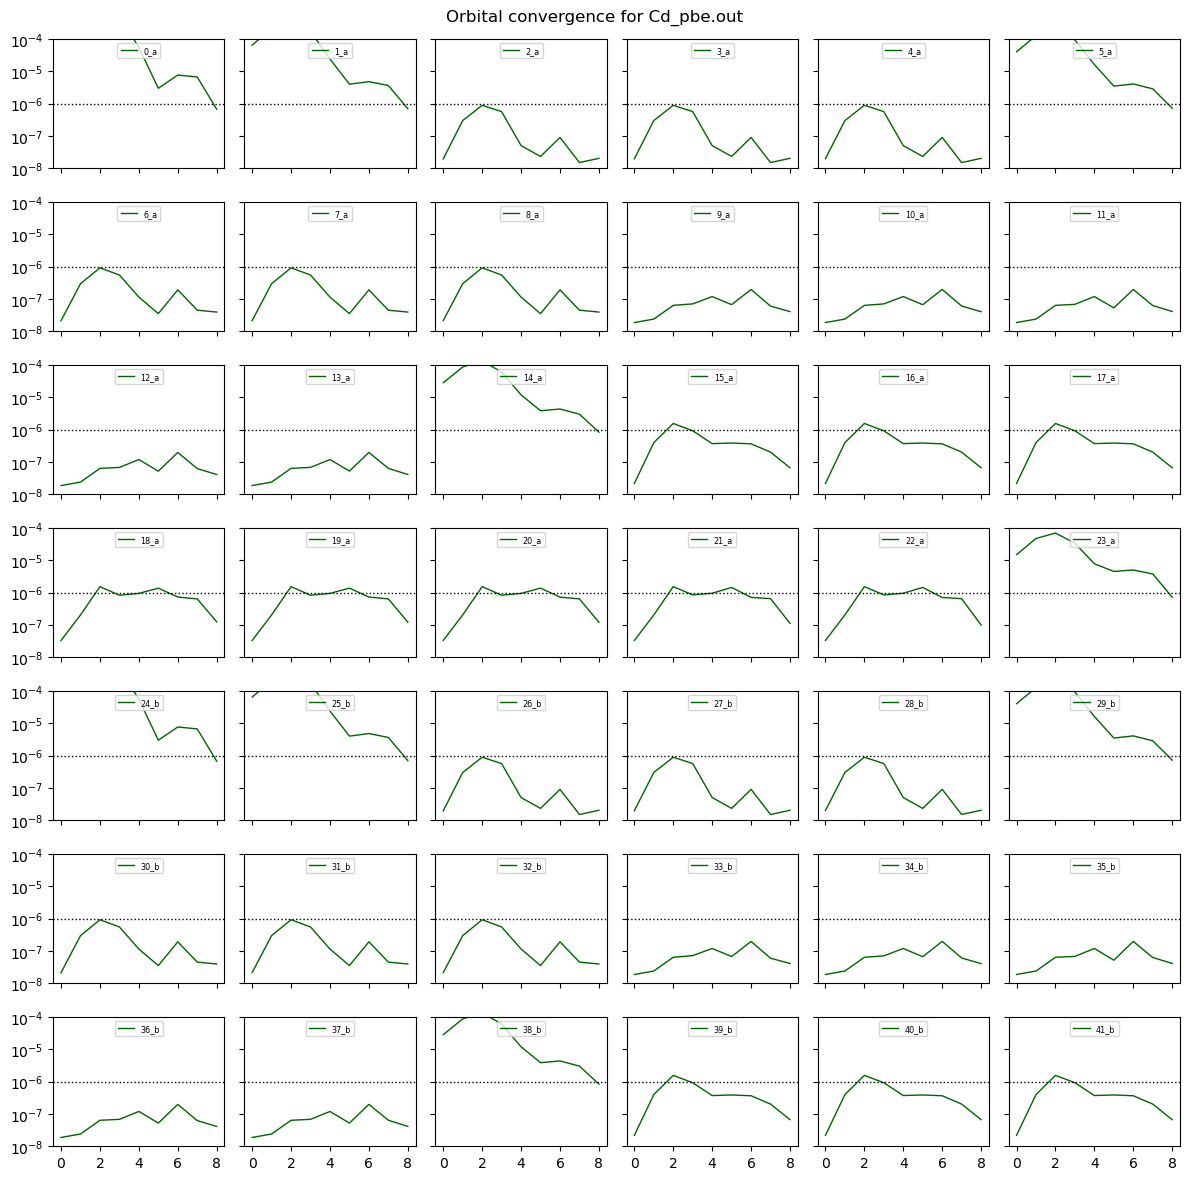

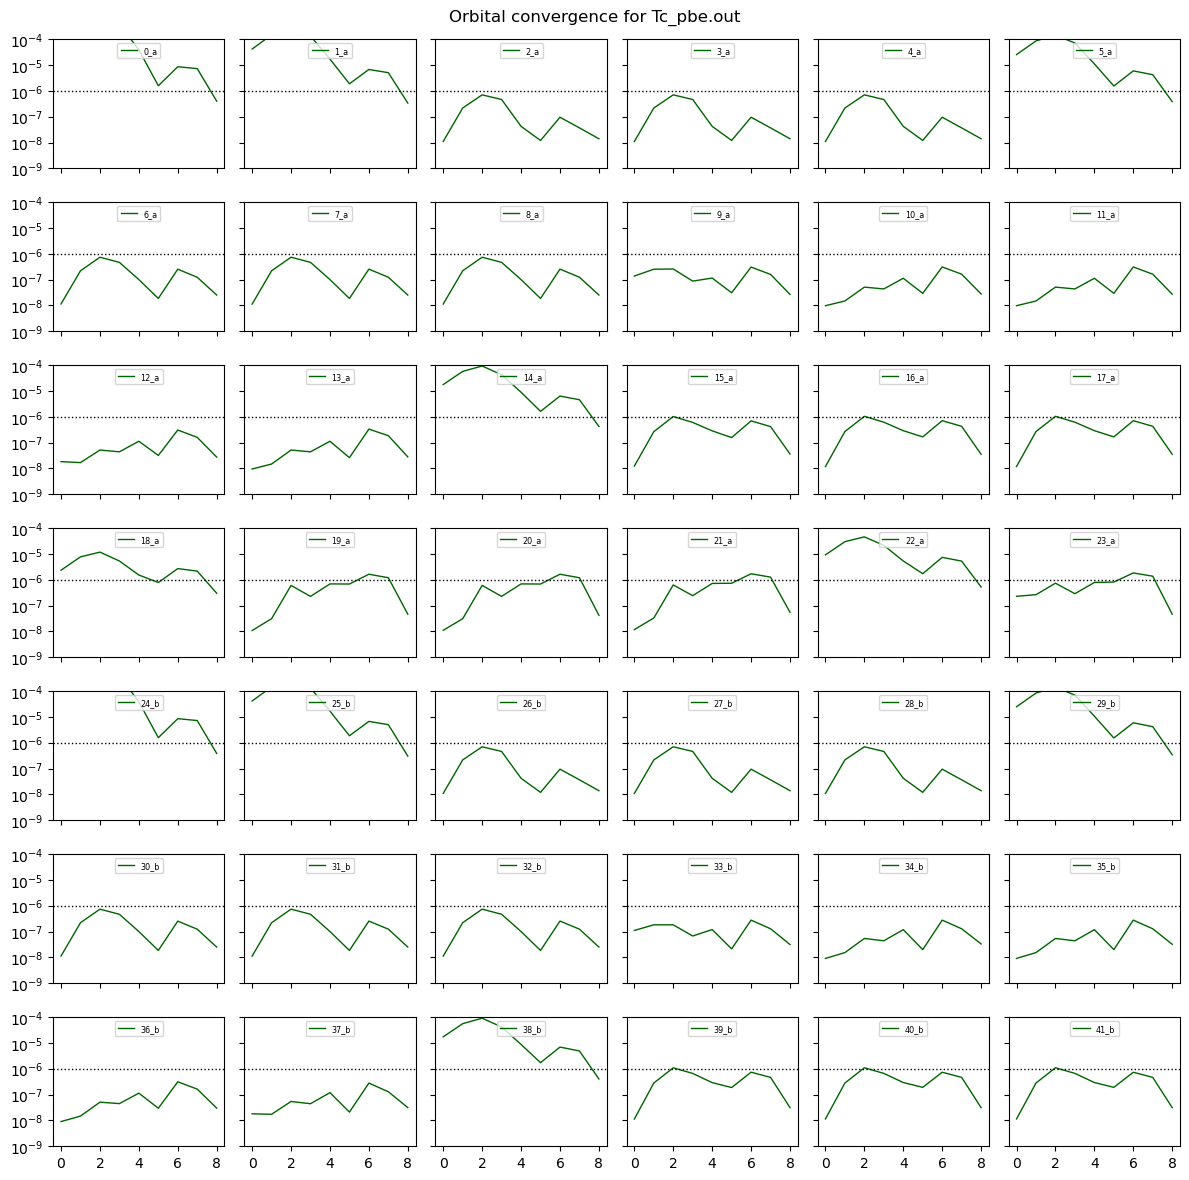

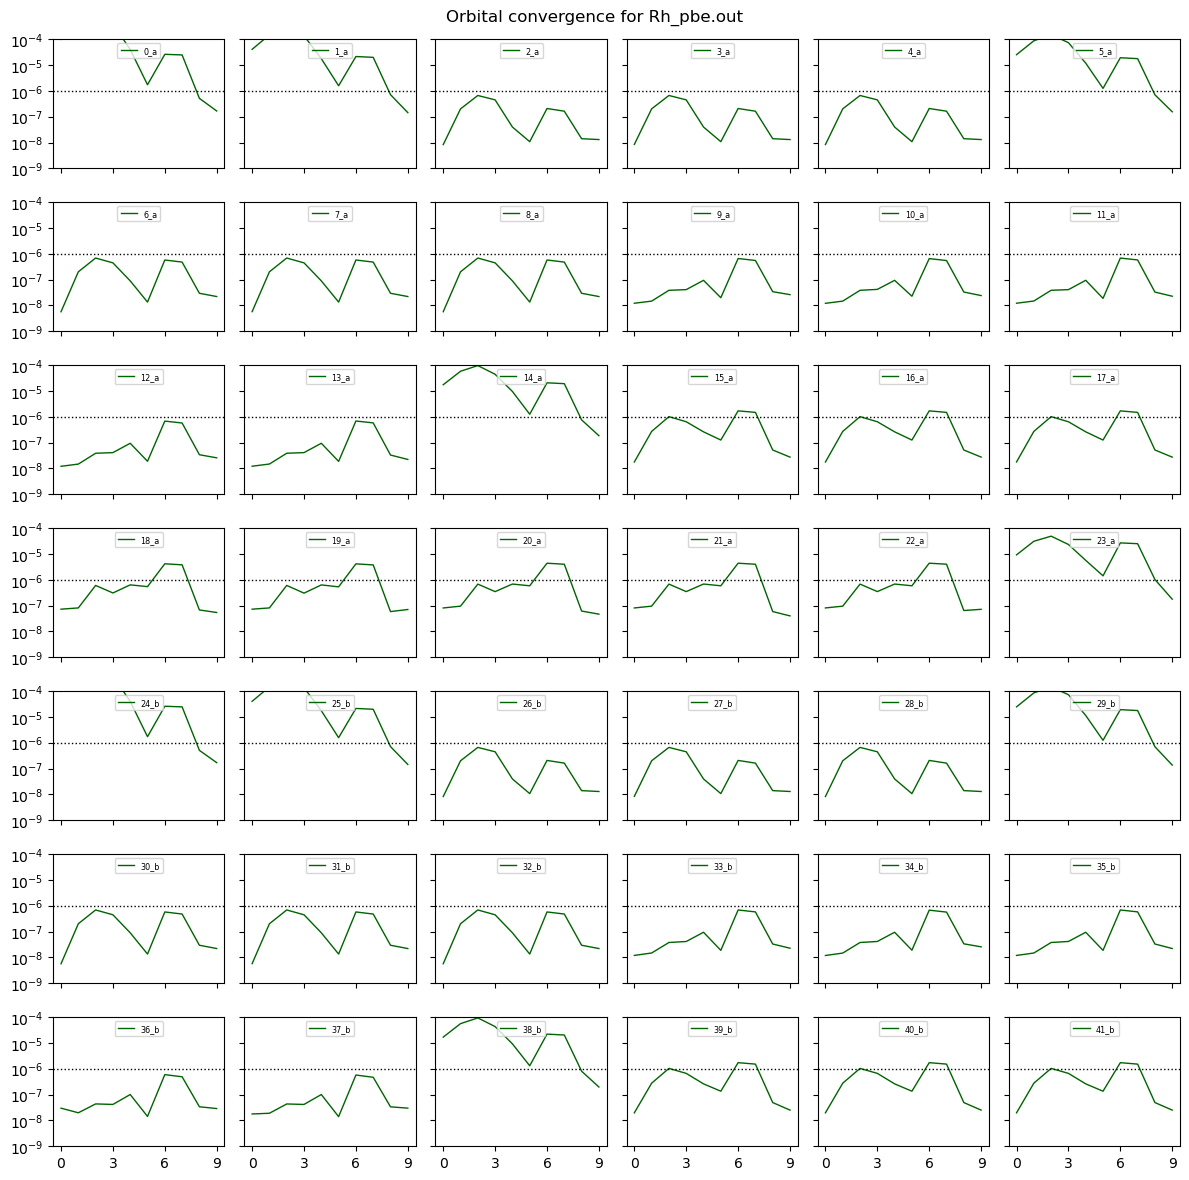

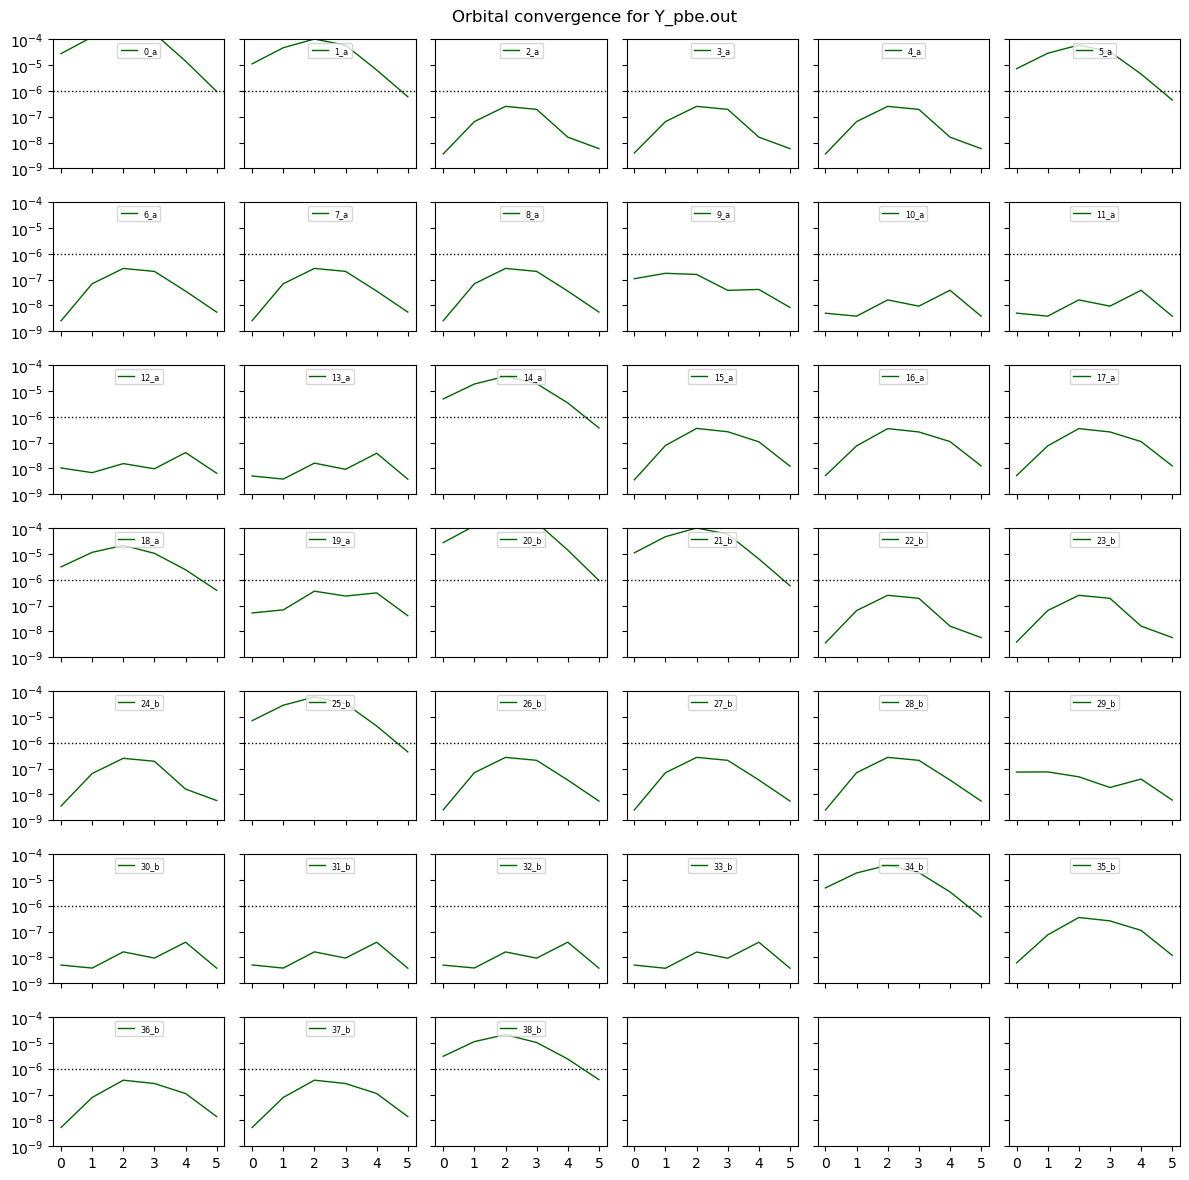

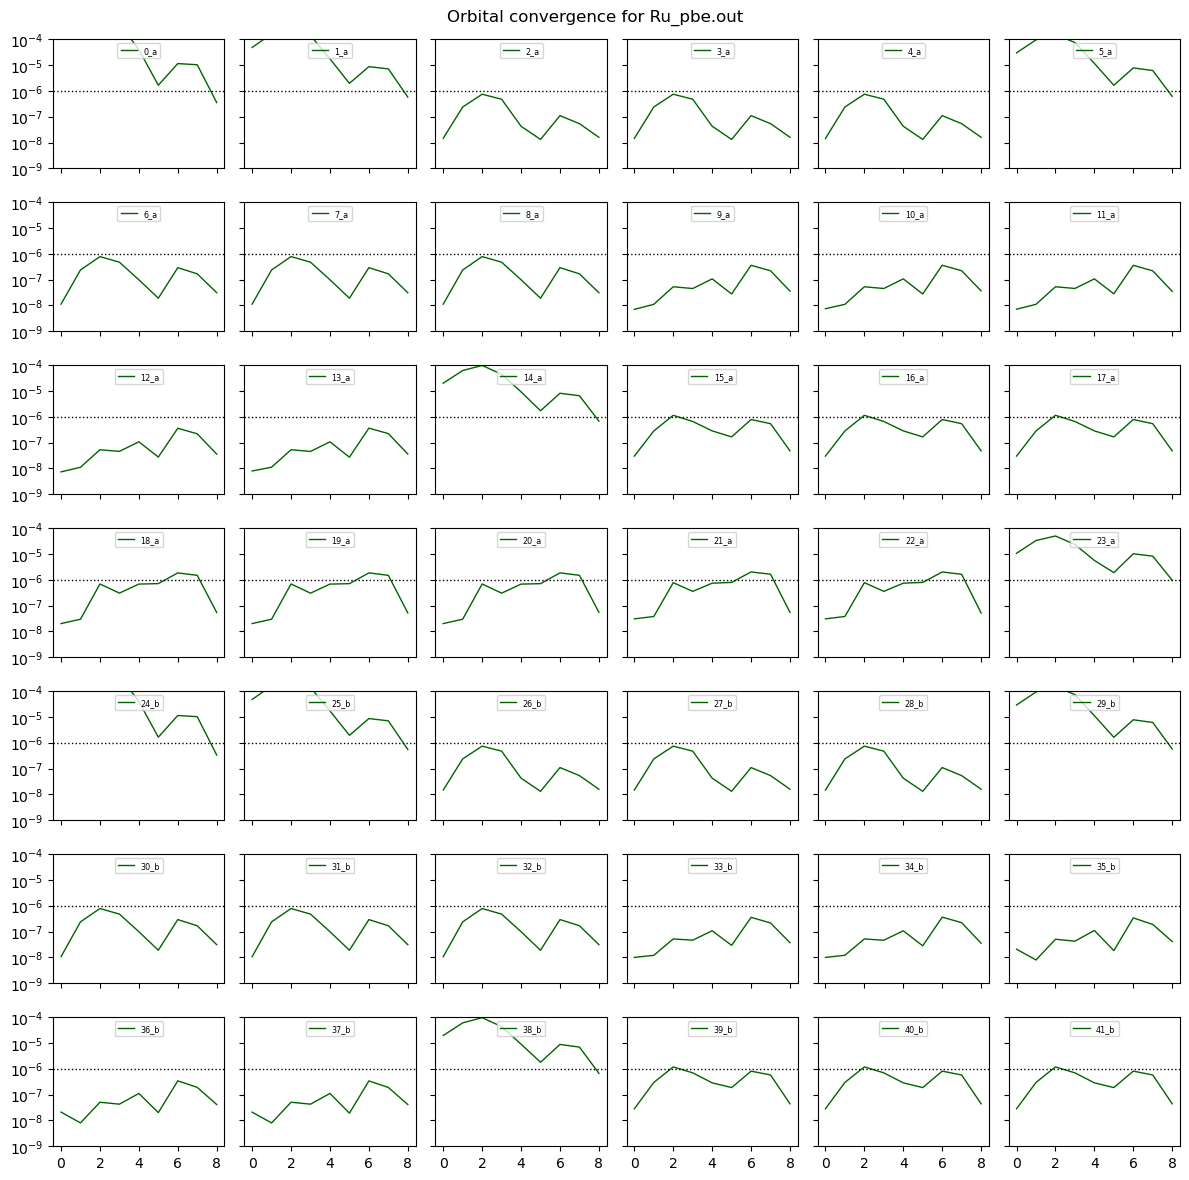

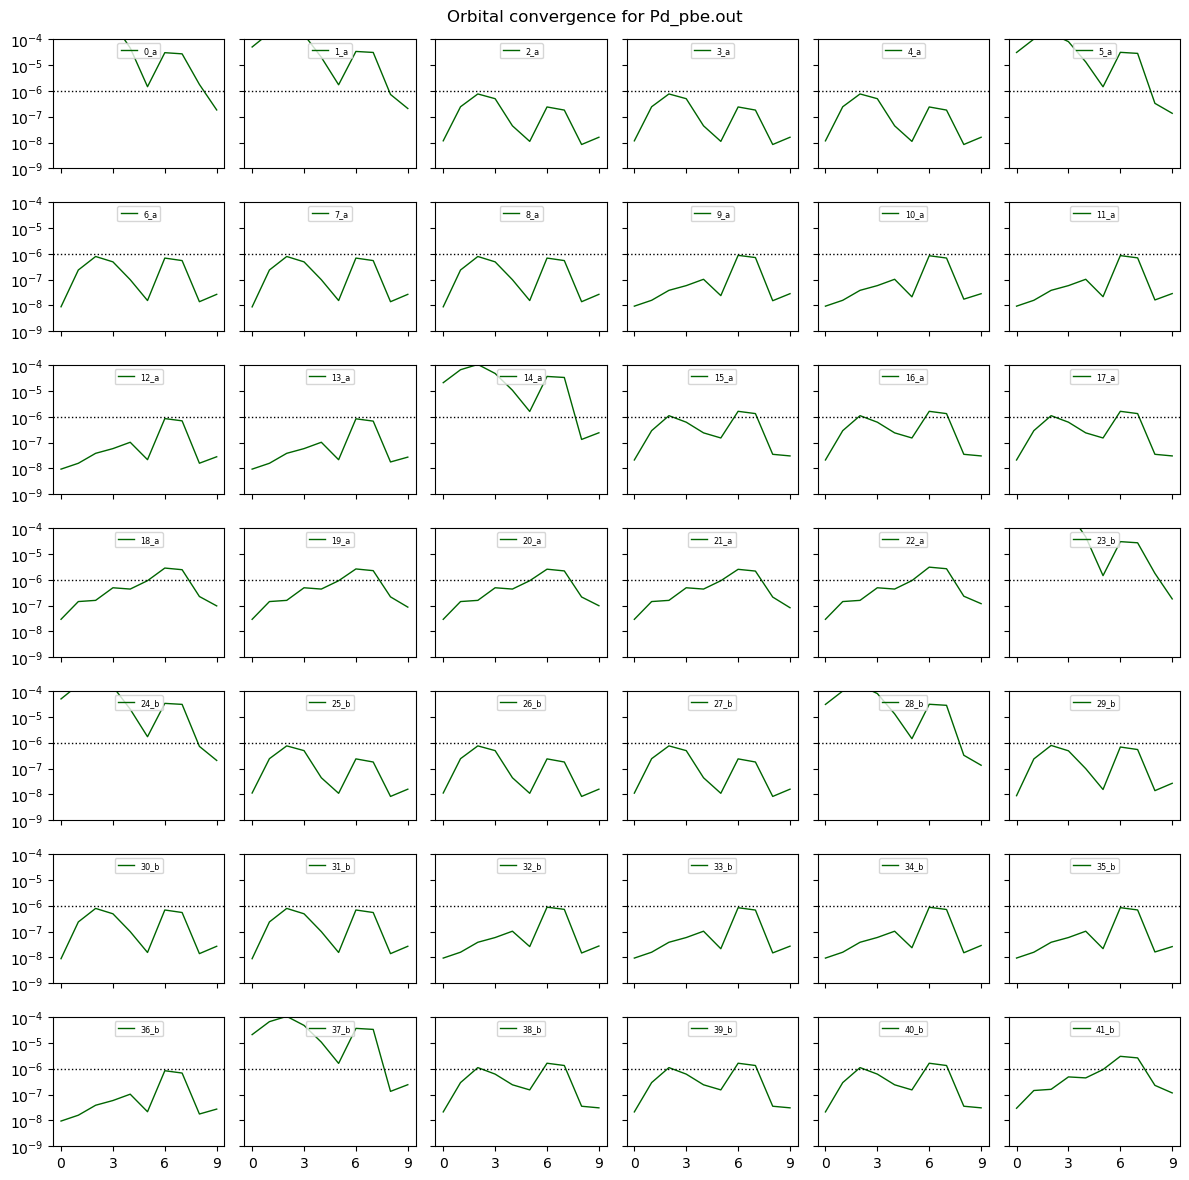

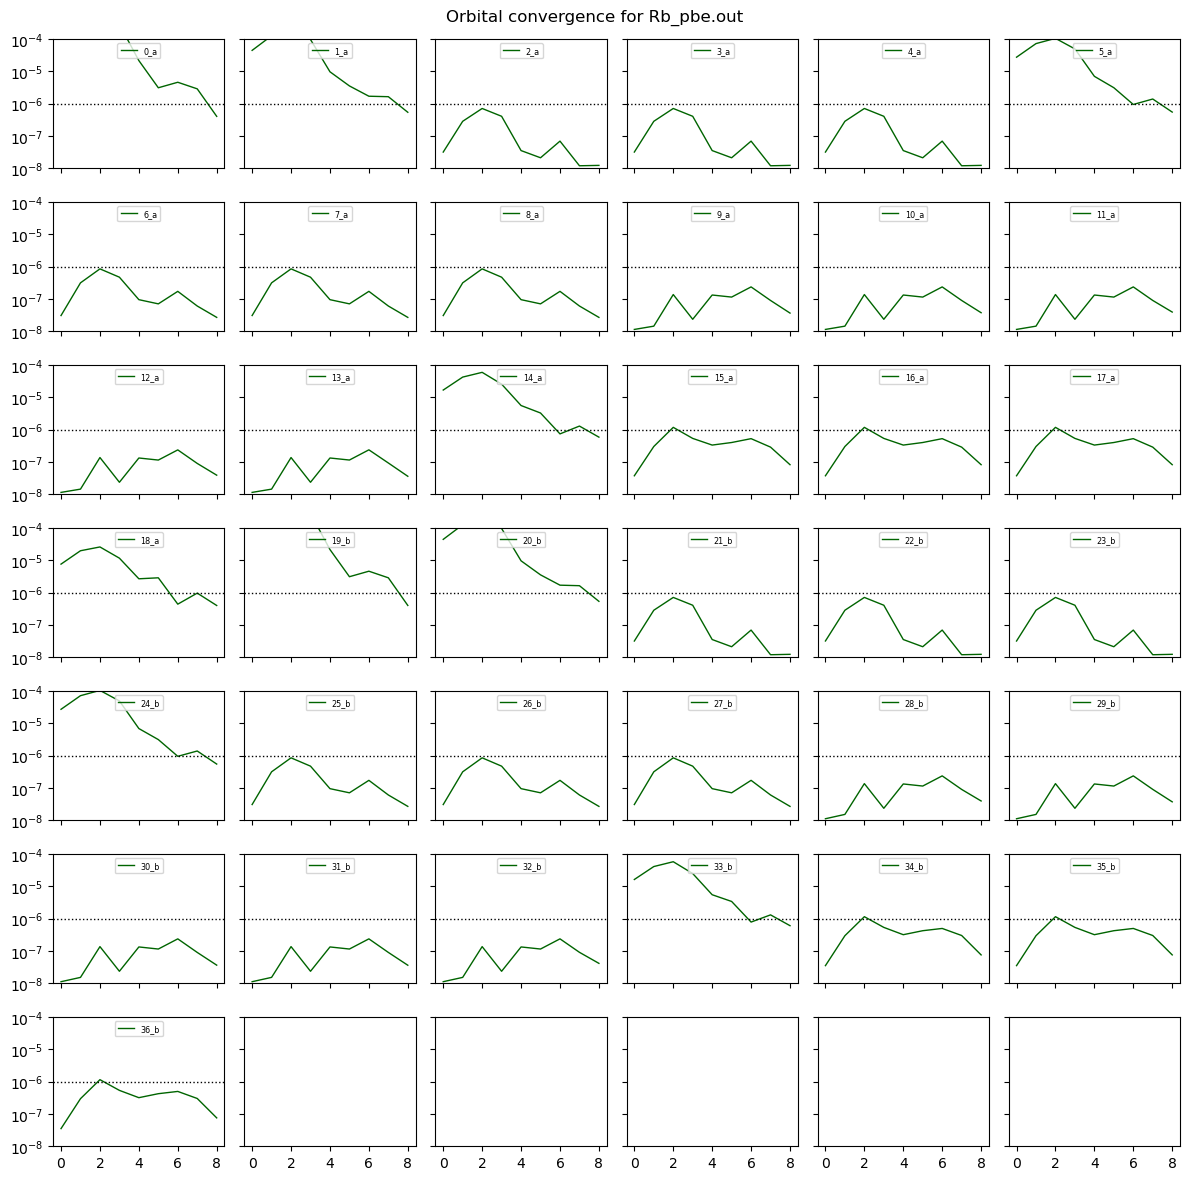

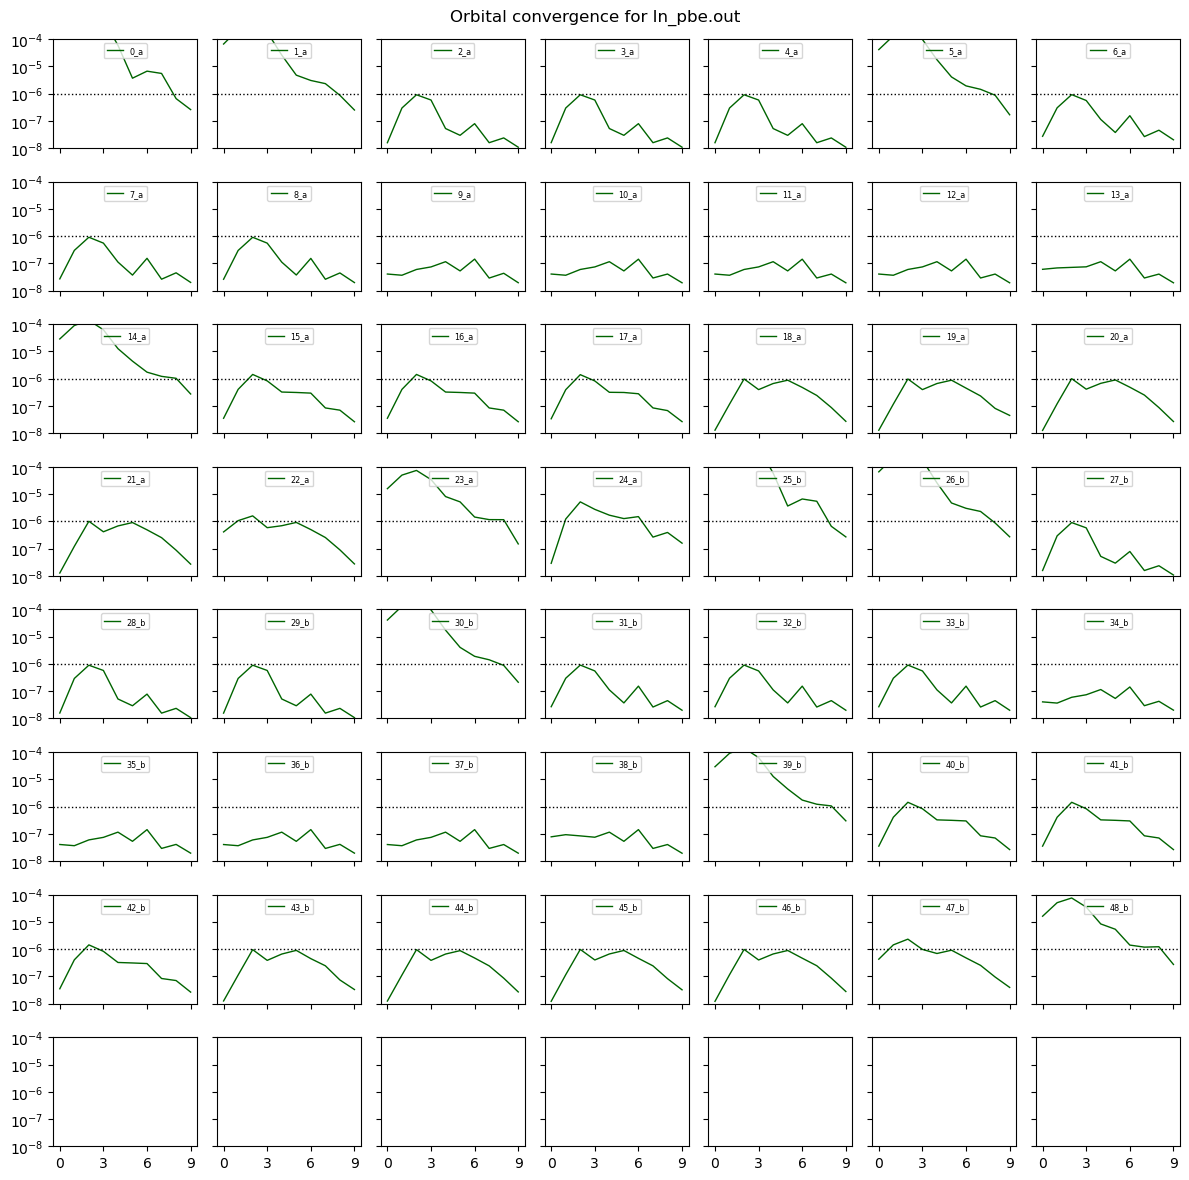

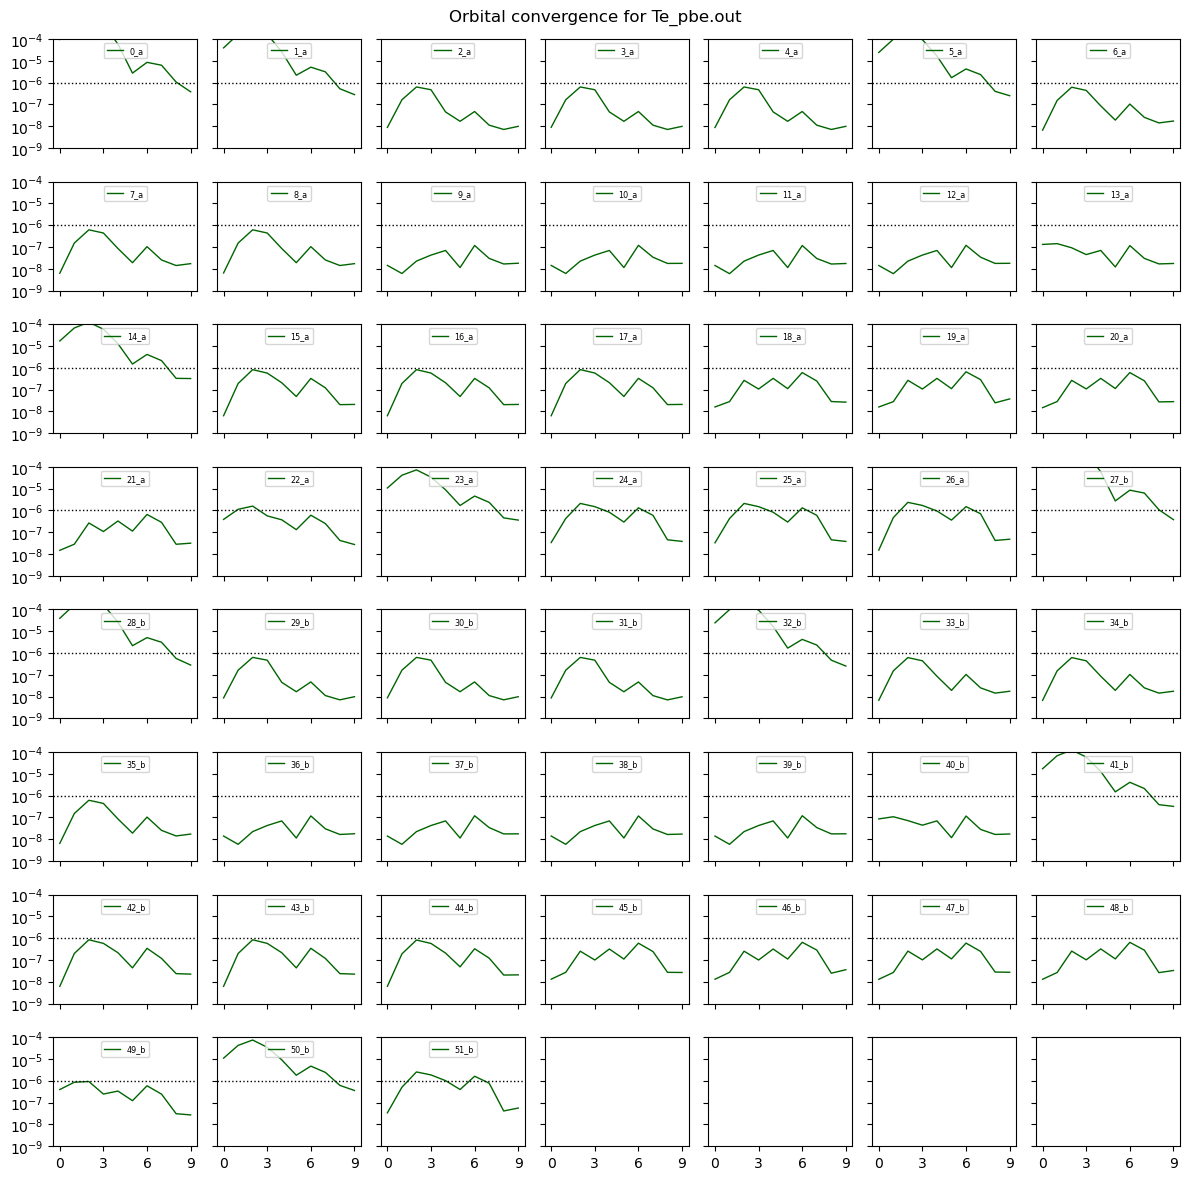

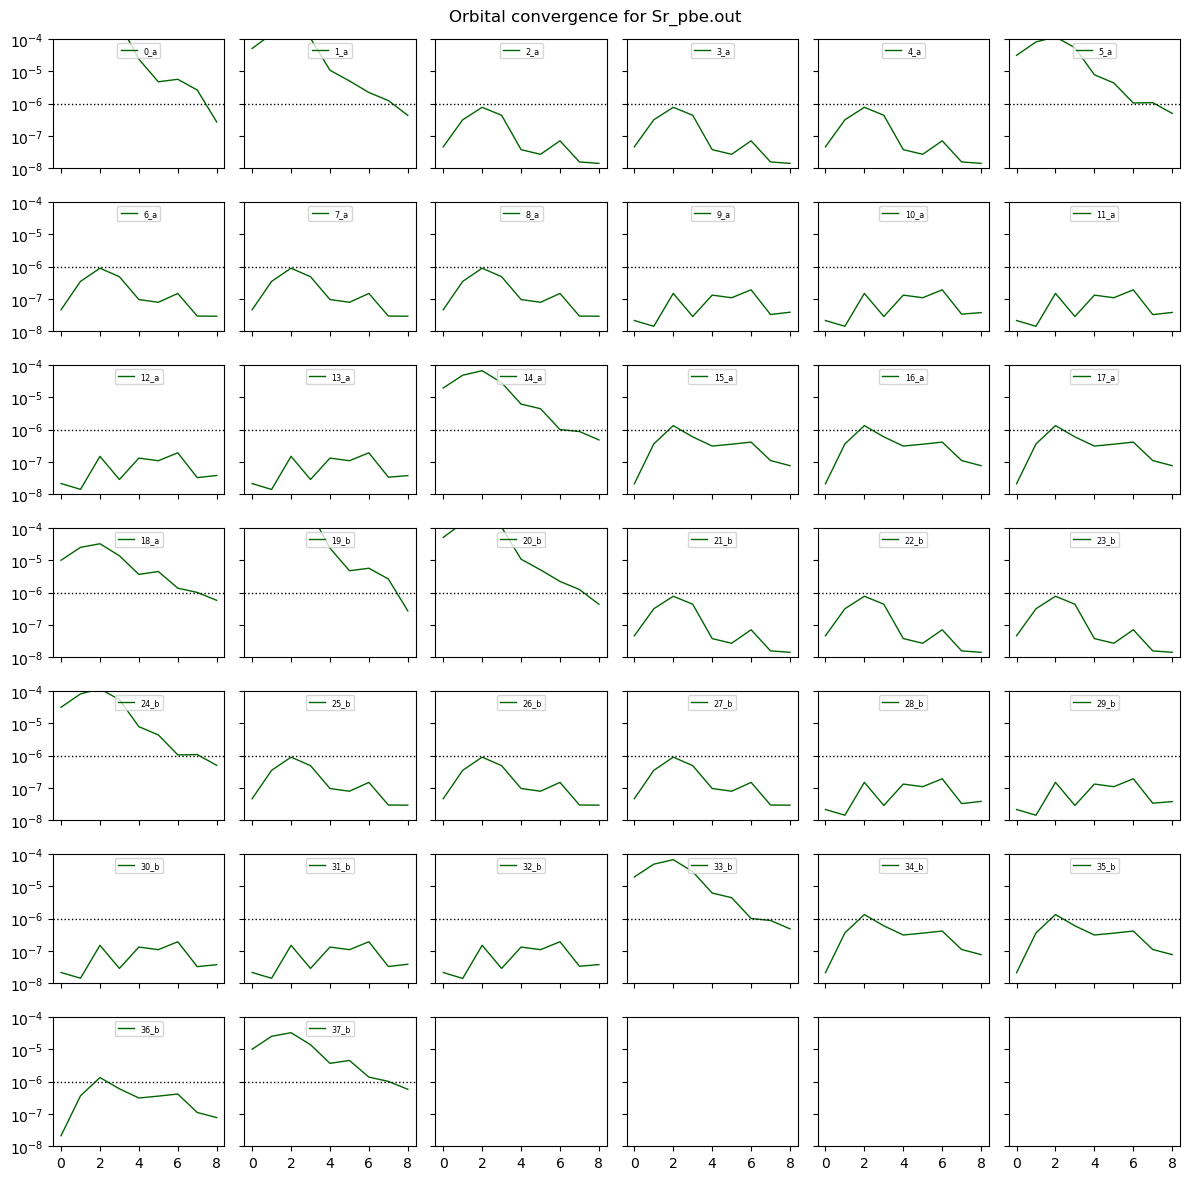

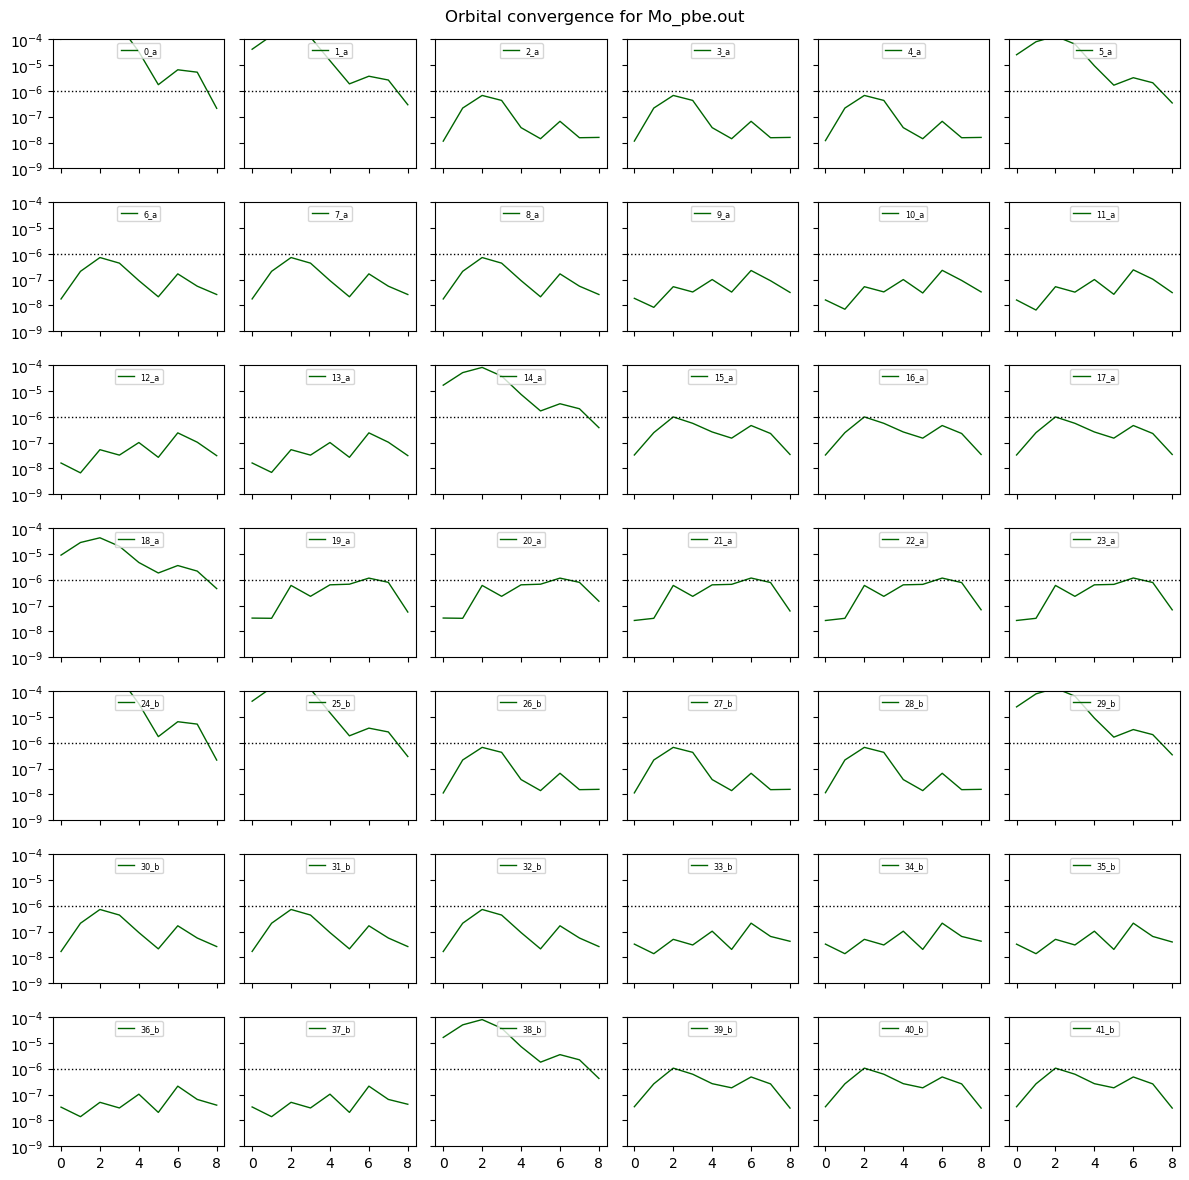

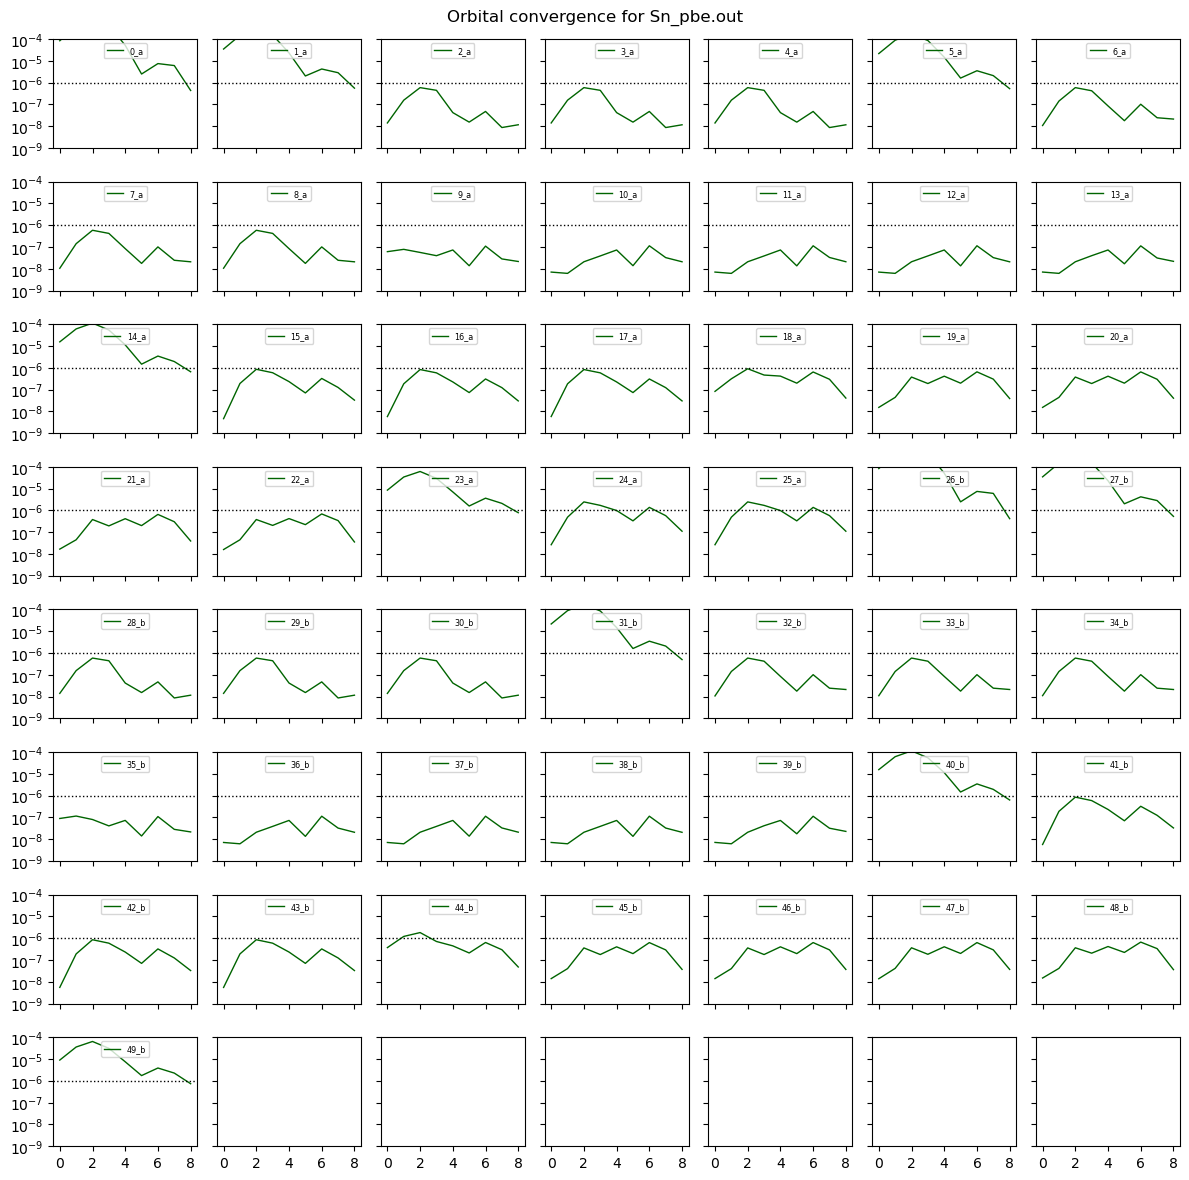

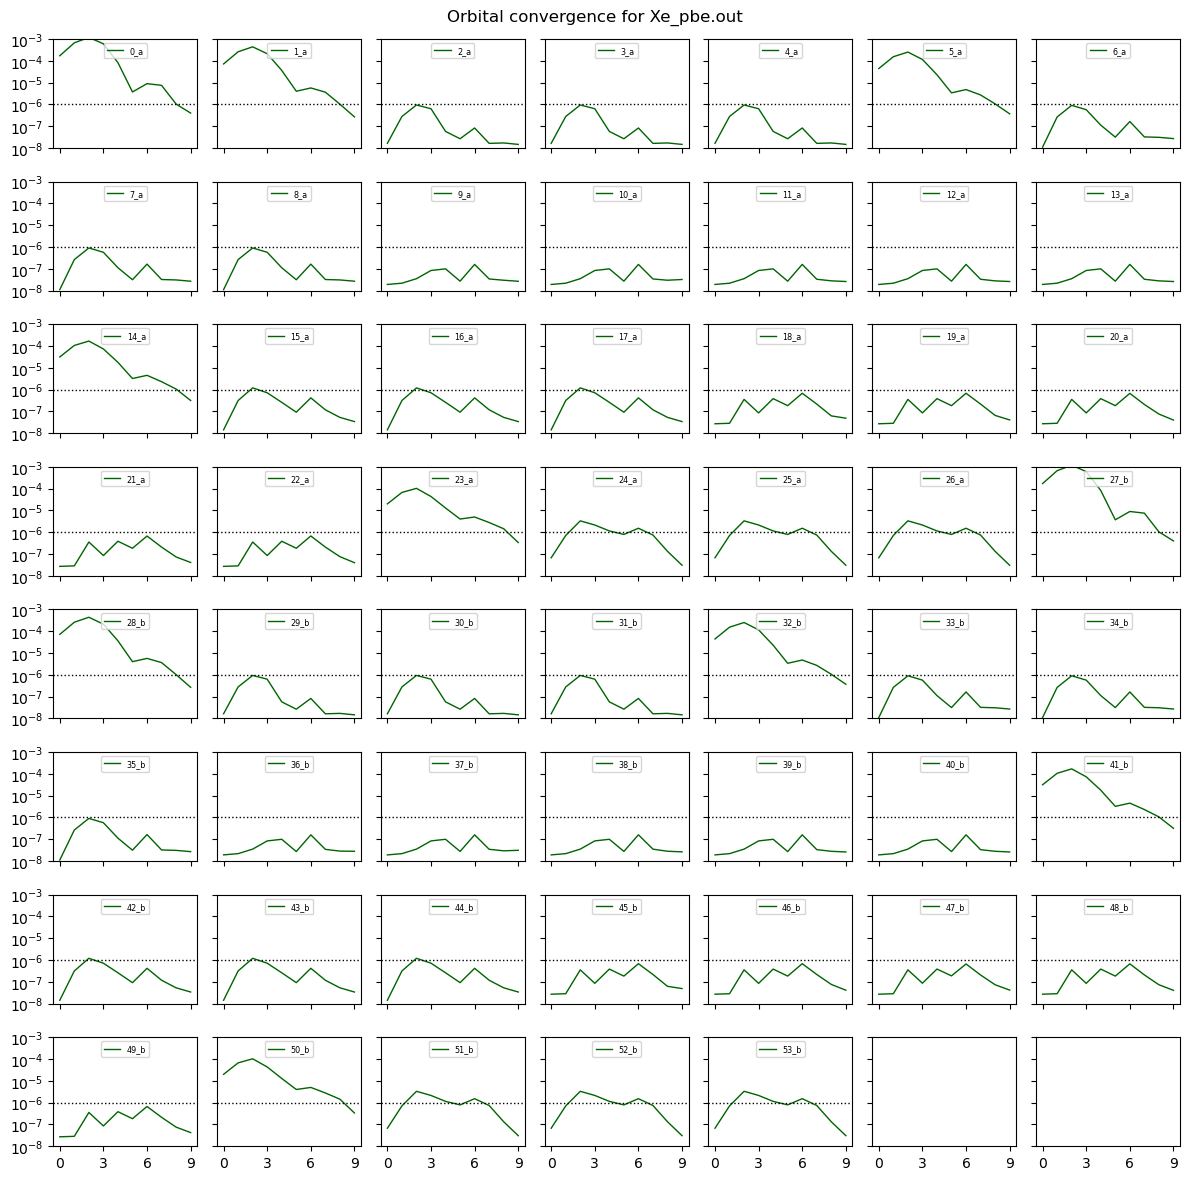

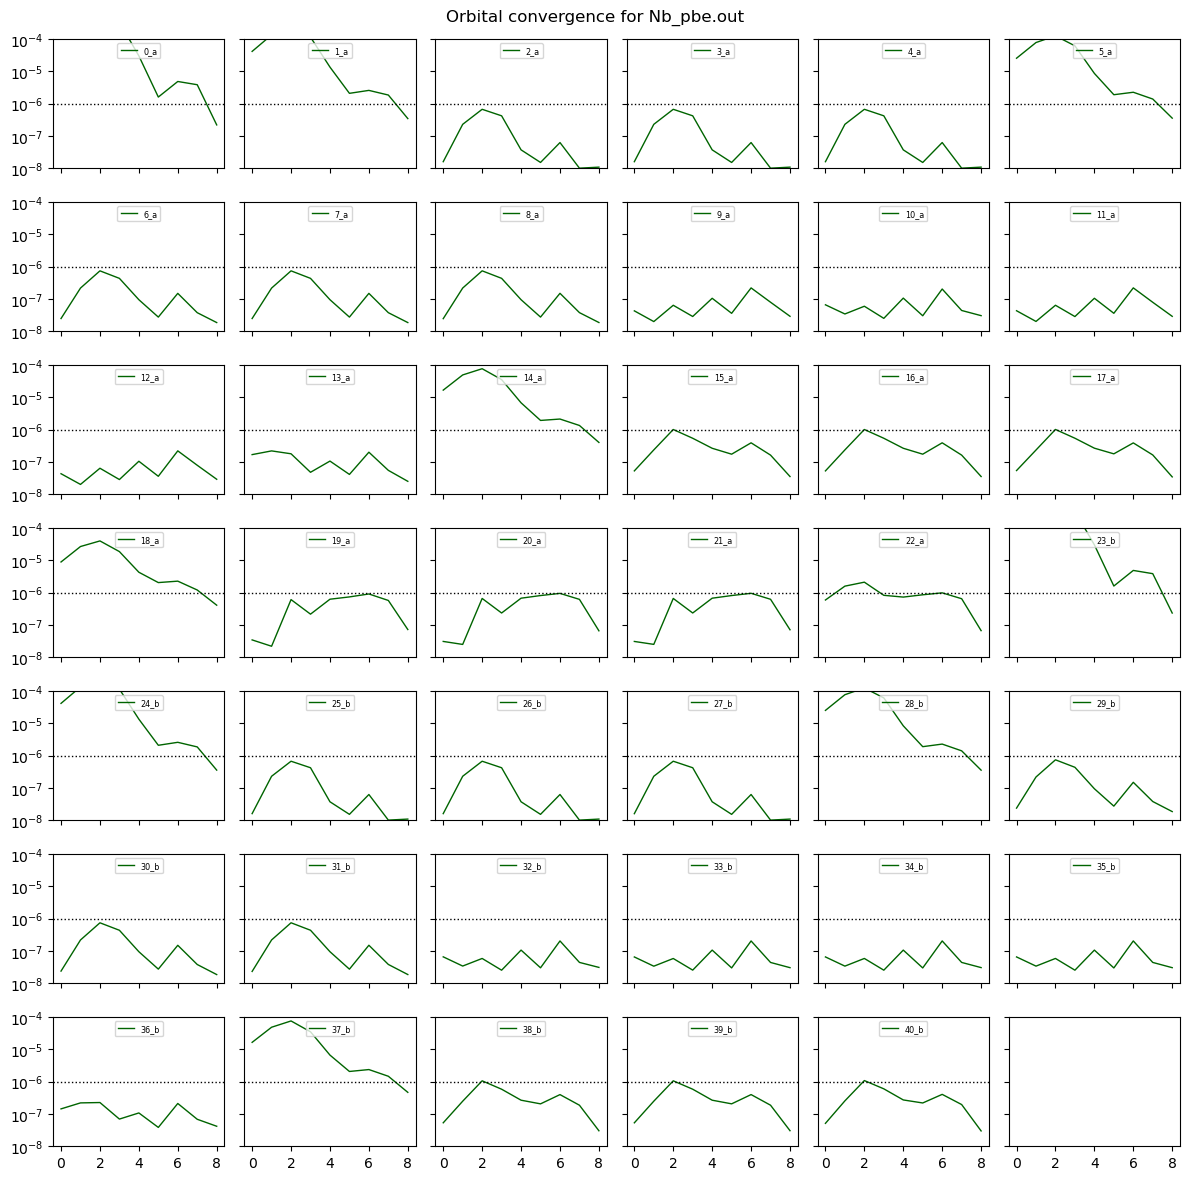

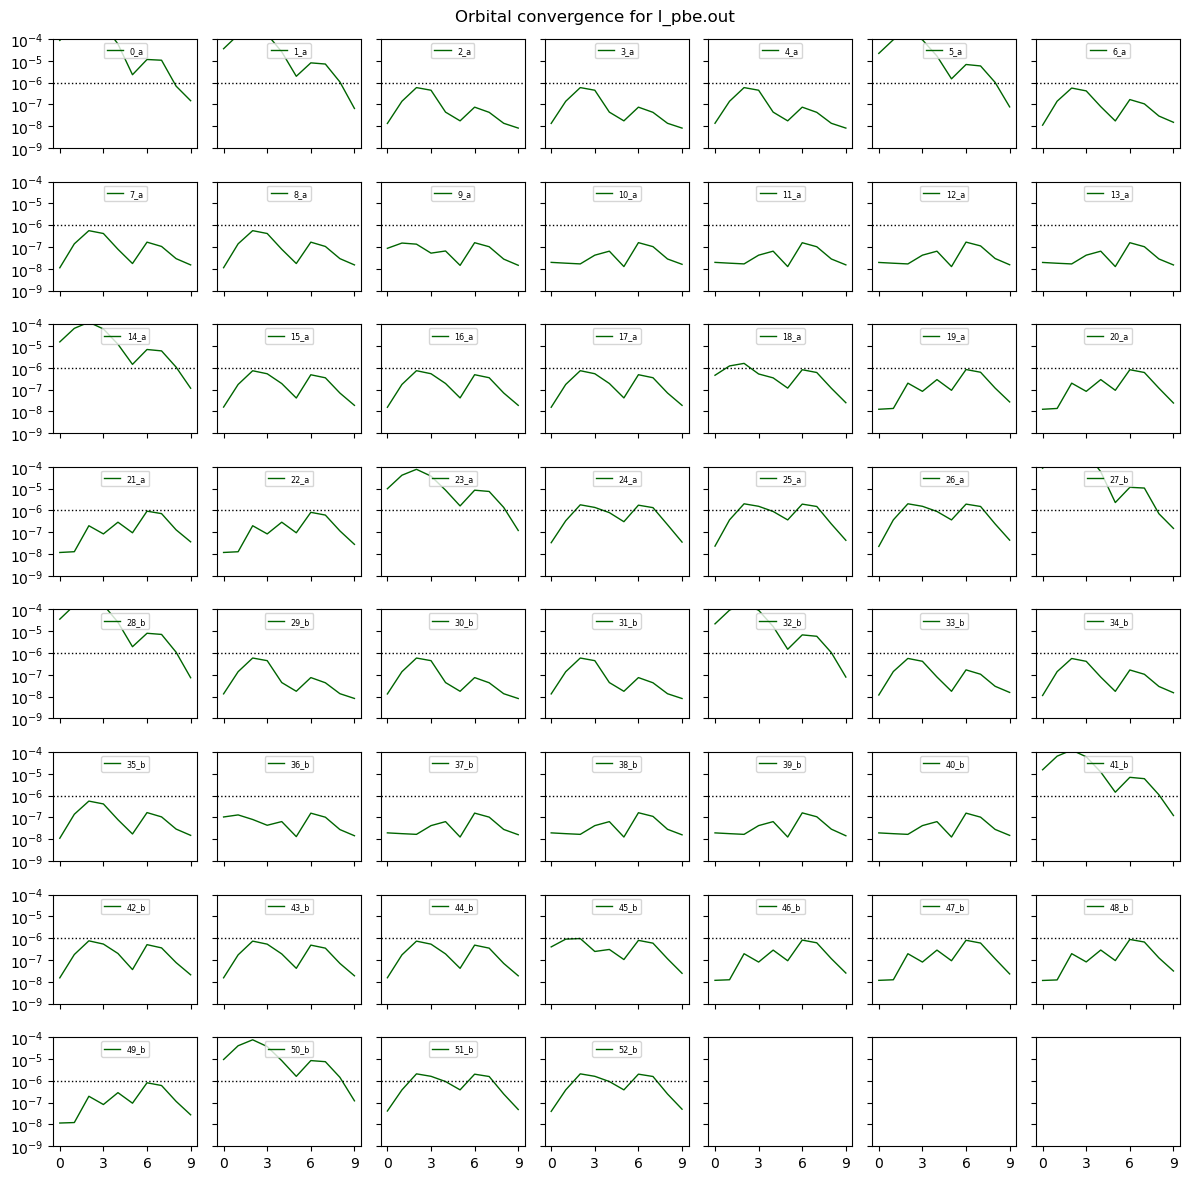

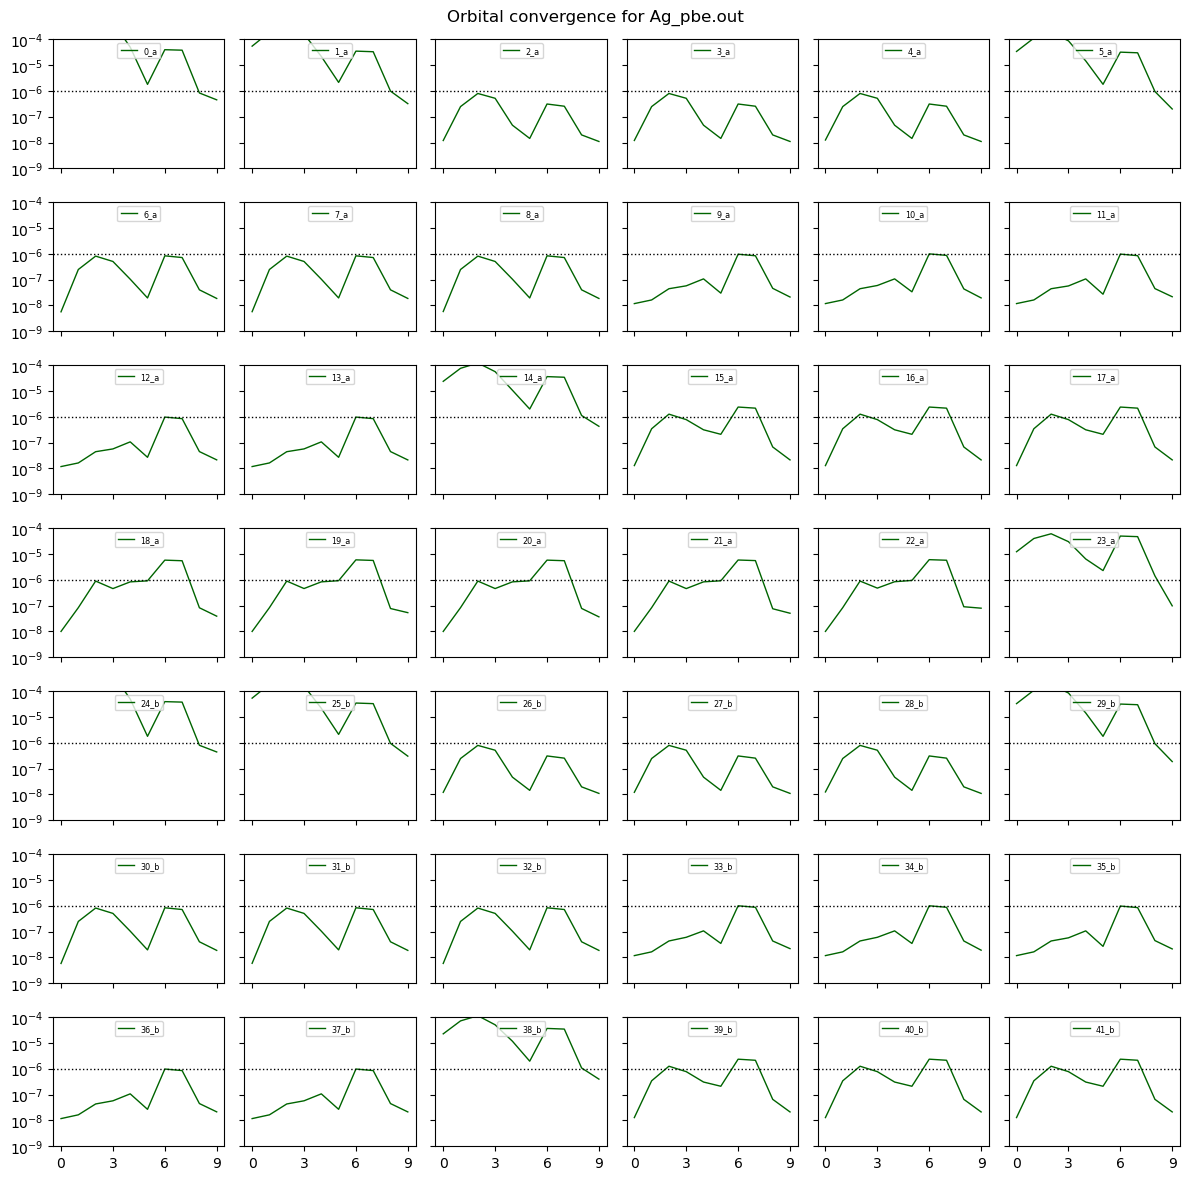

In [11]:
SAVEFIG = False

for f in files:
    print(f)
    with open(f) as file:
        lines = file.readlines()

    raw = getOrbitalResiduals(lines)
    df = pd.DataFrame(raw, columns=['Iteration', 'Index', 'Spin', 'Energy', 'Residual', 'Done']).sort_values(by=['Spin', 'Iteration'])

    norbs = getNumOrbitals(lines)
    dim = int(np.floor(np.sqrt(norbs)))
    orbital_thrs = getThresholds(lines)[-1]

    yticks = getyTicks(df.Residual)

    fig, axes = plt.subplots(nrows=dim+1, ncols=dim, figsize=(12,12), sharex=True, sharey=True, dpi=100)

    for ax, (idx, g) in zip(axes.flat, df.groupby(['Index'])):
        ax.set_yscale('log')
        ax.yaxis.set_major_locator(LogLocator())
        ax.xaxis.set_major_locator(MultipleLocator(g.size//10//2))
        ax.set_ylim(min(yticks), max(yticks))
        ax.set_yticks(yticks)

        spin = g.Spin.values[0]
        minval = np.min(g.Residual)
        ax.plot(g.Iteration, g.Residual, lw=1, color='darkgreen' if minval < orbital_thrs else 'crimson', label=f'{idx}_{spin}')
        ax.axhline(orbital_thrs, ls=':', lw=1, color='black')
        ax.legend(loc='upper center', bbox_to_anchor=[0.5, 1], fontsize='xx-small')

    fig.suptitle(f'Orbital convergence for {Path(f).name}')
    fig.tight_layout()

    if SAVEFIG:
        fig.savefig(Path('').joinpath(Path(f).stem + '.png'), facecolor='white')